In [1]:
from google.colab import drive
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Import data from drive
drive.mount('/content/drive')
mat_file_path = '/content/drive/MyDrive/dataset/2024_2025_RAUS_dataset_arc/images_test3/frame_axes_data_20241216_2.mat'
data = scipy.io.loadmat(mat_file_path)
data_matrix = data['data_matrix']

# positions : positions buffer of ultrasound probe for each image
positions = data_matrix[:120, 9:12]
# x_vectors, y_vectors, z_vectors : vectors buffer of each plane
x_vectors = data_matrix[:120, 0:3]
y_vectors = data_matrix[:120, 3:6]
z_vectors = data_matrix[:120, 6:9]

# Calculate the center position in 3D frame (X, Y)
X_mean = np.mean([np.max(positions[:, 0]), np.min(positions[:, 0])])
Y_mean = np.mean([np.max(positions[:, 1]), np.min(positions[:, 1])])
# Calculate the highest position in 3D frame (Z)
Z_max = np.max(positions[:, 2])


print(X_mean)
print(Y_mean)
print(Z_max)

plane_equations = []

# Generate buffer that express plane equation of each plane
for i in range(len(positions)):

    a, b, c = z_vectors[i]
    x0, y0, z0 = positions[i]
    d = a * x0 + b * y0 + c * z0

    plane_equations.append((a, b, c, d))

# Image template for importing images
bscan_image_template = '/content/drive/MyDrive/dataset/2024_2025_RAUS_dataset_arc/images_test3/{}_bmode.png'

# Calculate range x, y, z range using X_mean, Y_mean, and Z_max
x_range = (X_mean - 0.012, X_mean + 0.013)
y_range = (Y_mean - 0.010, Y_mean + 0.010)
z_range = (Z_max - 0.030, Z_max)

# Generate query points using linspace function
x = np.linspace(*x_range, int(50 * 15.0) )
y = np.linspace(*y_range, int(40 * 15.0) )
z = np.linspace(*z_range, int(60 * 15.0) )

distances = []
projections = []
plane_images = []

# Generate plane_images by importing B-scan images
for idx in tqdm(range(len(plane_equations)), desc="Processing"):
    bscan_image_path = bscan_image_template.format(idx)

    image = cv2.imread(bscan_image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {bscan_image_path}")

    plane_images.append(image)

len_pxl_width = 371
len_pxl_height = 1083
len_mm_width = 25.0
len_mm_height = 30.0
ratio_of_width = len_mm_width / len_pxl_width / 1000  # width (m) per pixel
ratio_of_height = len_mm_height / len_pxl_height / 1000  # height (m) per pixel

interpolated_intensities = []

Mounted at /content/drive
0.29704598735568455
0.10757069163438071
0.03955516941874149


Processing: 100%|██████████| 120/120 [00:41<00:00,  2.91it/s]


In [2]:
import numpy as np
import cupy as cp
from tqdm import tqdm


plane_origins_cpu = positions.astype(np.float32)   # shape (N, 3)
plane_normals_cpu = z_vectors.astype(np.float32)   # shape (N, 3)

# Build query_points in float32
query_points_cpu = np.array(
    np.meshgrid(x, y, z, indexing='ij'),
    dtype=np.float32
).transpose(1, 2, 3, 0)  # shape: (A, B, C, 3)

N = plane_origins_cpu.shape[0]
A, B, C, _ = query_points_cpu.shape

# Bring query_points data to GPU
query_points_gpu = cp.asarray(query_points_cpu, dtype=cp.float32)

# Initialize arrays to track only the top two distances and plane indices (best_val1 : Closest distance, best_val2 : Second closest distance, best_idx1 : Index of closest plane, best_idx2 : Index of second closest plane)
best_val1 = cp.full((A, B, C), cp.inf, dtype=cp.float32)
best_val2 = cp.full((A, B, C), cp.inf, dtype=cp.float32)
best_idx1 = cp.full((A, B, C), -1,      dtype=cp.int32)
best_idx2 = cp.full((A, B, C), -1,      dtype=cp.int32)

# Process planes in batches to limit GPU memory usage
# Adjust batch_size to fit your GPU; smaller = less memory, slower speed.
batch_size = 5

for start in range(0, N, batch_size):
    end = min(start + batch_size, N)

    # Copy plane data for this batch to GPU as float32
    plane_origins_gpu = cp.asarray(plane_origins_cpu[start:end], dtype=cp.float32)  # shape: (batch_size, 3)
    plane_normals_gpu = cp.asarray(plane_normals_cpu[start:end], dtype=cp.float32)  # shape: (batch_size, 3)

    # Process each plane in the batch
    for i in range(end - start):
        plane_index = start + i  # actual global plane index

        # Signed distance from plane i to all (x,y,z) in query_points
        distance_i = (
              (query_points_gpu[..., 0] - plane_origins_gpu[i, 0]) * plane_normals_gpu[i, 0]
            + (query_points_gpu[..., 1] - plane_origins_gpu[i, 1]) * plane_normals_gpu[i, 1]
            + (query_points_gpu[..., 2] - plane_origins_gpu[i, 2]) * plane_normals_gpu[i, 2]
        )

        abs_distance_i = cp.abs(distance_i)

        # Check if abs_distance_i beats the current #1 best distance
        mask1 = abs_distance_i < best_val1

        # Put abs_distance into new #1 and old #1 into #2 where mask1 is True (abs_distance -> New #1, Old #1 -> New #2)
        best_val2 = cp.where(mask1, best_val1, best_val2)
        best_idx2 = cp.where(mask1, best_idx1, best_idx2)
        best_val1 = cp.where(mask1, abs_distance_i, best_val1)
        best_idx1 = cp.where(mask1, plane_index, best_idx1)

        # Among those not improved by mask1, see if abs_distance_i beats #2
        mask2 = (~mask1) & (abs_distance_i < best_val2)

        # Update the best and second-best holders
        best_val2 = cp.where(mask2, abs_distance_i, best_val2)
        best_idx2 = cp.where(mask2, plane_index, best_idx2)

# Stack the plane indices and distancesof the two closest planes:
closest_planes_gpu = cp.stack([best_idx1, best_idx2], axis=0)       # shape (2, A, B, C)
closest_distances_gpu = cp.stack([best_val1, best_val2], axis=0)   # shape (2, A, B, C)

print("closest_planes_gpu shape:", closest_planes_gpu.shape, closest_planes_gpu.dtype)
print("closest_distances_gpu shape:", closest_distances_gpu.shape, closest_distances_gpu.dtype)

# Bring them to the CPU
closest_planes_cpu = cp.asnumpy(closest_planes_gpu)
closest_distances_cpu = cp.asnumpy(closest_distances_gpu)


closest_planes_gpu shape: (2, 750, 600, 900) int32
closest_distances_gpu shape: (2, 750, 600, 900) float32


In [3]:
# Bring closest_planes and closest_distances to the CPU
closest_planes = cp.asnumpy(closest_planes_cpu)
closest_distances = cp.asnumpy(closest_distances_cpu)

print("closest_planes_cpu shape:", closest_planes.shape)
print("closest_distances_cpu shape:", closest_distances.shape)

closest_planes_cpu shape: (2, 750, 600, 900)
closest_distances_cpu shape: (2, 750, 600, 900)


In [4]:
import numpy as np

# Cast plane indices to int16
first_closest_plane_indices = closest_planes[0, ...].astype(np.int16)
second_closest_plane_indices = closest_planes[1, ...].astype(np.int16)

print(f"first_closest_plane_indices: {first_closest_plane_indices.shape}, dtype={first_closest_plane_indices.dtype}")
print(f"second_closest_plane_indices: {second_closest_plane_indices.shape}, dtype={second_closest_plane_indices.dtype}")

# Cast positions / x_vectors / y_vectors to float16 if not already (Memory Capacity)
positions = plane_origins_cpu.astype(np.float16)
x_vectors = x_vectors.astype(np.float16)
y_vectors = y_vectors.astype(np.float16)
query_points = query_points_cpu.astype(np.float16)

# Extract origins,x_vectors, y_vectors of the closest planes for all grid points (Memory Capacity)
origins1 = positions[first_closest_plane_indices].astype(np.float16)   # shape (A,B,C,3)
x_vectors1 = x_vectors[first_closest_plane_indices].astype(np.float16) # shape (A,B,C,3)
y_vectors1 = y_vectors[first_closest_plane_indices].astype(np.float16) # shape (A,B,C,3)

print(f"origins1: {origins1.shape}, dtype={origins1.dtype}")
print(f"x_vectors1: {x_vectors1.shape}, dtype={x_vectors1.dtype}")
print(f"y_vectors1: {y_vectors1.shape}, dtype={y_vectors1.dtype}")

# Extract origins,x_vectors, y_vectors of the second closest planes for all grid points (Memory Capacity)
origins2 = positions[second_closest_plane_indices].astype(np.float16)
x_vectors2 = x_vectors[second_closest_plane_indices].astype(np.float16)
y_vectors2 = y_vectors[second_closest_plane_indices].astype(np.float16)

# Calculate vector `v` from the origin to the query point
v1 = (query_points - origins1).astype(np.float16)  # shape (A,B,C,3)
v2 = (query_points - origins2).astype(np.float16)  # shape (A,B,C,3)

print(f"v1: {v1.shape}, dtype={v1.dtype}")
print(f"v2: {v2.shape}, dtype={v2.dtype}")

# Compute the projections on X and Y axes of two planes for all the query points (dot products)
v_x1 = np.sum((v1 * x_vectors1).astype(np.float16), axis=-1).astype(np.float16)
v_y1 = np.sum((v1 * y_vectors1).astype(np.float16), axis=-1).astype(np.float16)
print(f"v_x1: {v_x1.shape}, dtype={v_x1.dtype}")
print(f"v_y1: {v_y1.shape}, dtype={v_y1.dtype}")

v_x2 = np.sum((v2 * x_vectors2).astype(np.float16), axis=-1).astype(np.float16)
v_y2 = np.sum((v2 * y_vectors2).astype(np.float16), axis=-1).astype(np.float16)

# Convert ratio_of_width / ratio_of_height to float16 for consistency
ratio_of_height = np.float16(ratio_of_height)
ratio_of_width  = np.float16(ratio_of_width)

# Map to pixel coordinates
pixel_y1 = (v_x1 / ratio_of_height).astype(np.float16)
pixel_x1 = (v_y1 / ratio_of_width).astype(np.float16)
pixel_y2 = (v_x2 / ratio_of_height).astype(np.float16)
pixel_x2 = (v_y2 / ratio_of_width).astype(np.float16)

len_pxl_width  = np.int16(len_pxl_width)
len_pxl_height = np.int16(len_pxl_height)

# Adjust x and y coordinates
pixel_x_centered1 = (pixel_x1 + (len_pxl_width / 2)).astype(np.float16)
pixel_y_centered1 = pixel_y1
pixel_x_centered2 = (pixel_x2 + (len_pxl_width / 2)).astype(np.float16)
pixel_y_centered2 = pixel_y2

# Clamp pixel values to valid ranges
pixel_x_clamped1 = np.clip(pixel_x_centered1, 0, len_pxl_width - 1).astype(np.int16)
pixel_y_clamped1 = np.clip(pixel_y_centered1, 0, len_pxl_height - 1).astype(np.int16)

print(f"pixel_x_clamped1: {pixel_x_clamped1.shape}, dtype={pixel_x_clamped1.dtype}")
print(f"pixel_y_clamped1: {pixel_y_clamped1.shape}, dtype={pixel_y_clamped1.dtype}")

pixel_x_clamped2 = np.clip(pixel_x_centered2, 0, len_pxl_width - 1).astype(np.int16)
pixel_y_clamped2 = np.clip(pixel_y_centered2, 0, len_pxl_height - 1).astype(np.int16)


first_closest_plane_indices: (750, 600, 900), dtype=int16
second_closest_plane_indices: (750, 600, 900), dtype=int16
origins1: (750, 600, 900, 3), dtype=float16
x_vectors1: (750, 600, 900, 3), dtype=float16
y_vectors1: (750, 600, 900, 3), dtype=float16
v1: (750, 600, 900, 3), dtype=float16
v2: (750, 600, 900, 3), dtype=float16
v_x1: (750, 600, 900), dtype=float16
v_y1: (750, 600, 900), dtype=float16
pixel_x_clamped1: (750, 600, 900), dtype=int16
pixel_y_clamped1: (750, 600, 900), dtype=int16


In [5]:
# Delete buffers that are not used anymore.

plane_images = np.array(plane_images)  # Convert list to NumPy array
print(plane_images.shape)

(120, 1083, 371)


In [6]:
import numpy as np

# Generate grid indices for dimensions
grid_x, grid_y, grid_z = np.meshgrid(
    np.arange(first_closest_plane_indices.shape[0]),
    np.arange(first_closest_plane_indices.shape[1]),
    np.arange(first_closest_plane_indices.shape[2]),
    indexing="ij",
)

# Extract intensities for the two closest planes
intensities1 = plane_images[
    first_closest_plane_indices,
    pixel_y_clamped1,
    pixel_x_clamped1,
]
intensities2 = plane_images[
    second_closest_plane_indices,
    pixel_y_clamped2,
    pixel_x_clamped2,
]

print(intensities1.shape)
print(intensities2.shape)

(750, 600, 900)
(750, 600, 900)


In [7]:
# Calculate weights for interpolation
weight1 = 1 / best_val1 / (1 / best_val1 + 1 / best_val2)
weight2 = 1 / best_val2 / (1 / best_val1 + 1 / best_val2)

weight1 = cp.asnumpy(weight1)
intensities1 = cp.asnumpy(intensities1)
weight2 = cp.asnumpy(weight2)
intensities2 = cp.asnumpy(intensities2)

print(weight1.shape)
print(weight2.shape)

# Perform weighted interpolation
interpolated_intensity = weight1 * intensities1 + weight2 * intensities2
print(interpolated_intensity.shape)

(750, 600, 900)
(750, 600, 900)
(750, 600, 900)


In [8]:
# Distance for plane 0
distance_0 = (
    (query_points[..., 0] - plane_origins_cpu[0, 0]) * plane_normals_cpu[0, 0] +
    (query_points[..., 1] - plane_origins_cpu[0, 1]) * plane_normals_cpu[0, 1] +
    (query_points[..., 2] - plane_origins_cpu[0, 2]) * plane_normals_cpu[0, 2]
)

# Distance for plane -1 (the last plane)
distance_last = (
    (query_points[..., 0] - plane_origins_cpu[-1, 0]) * plane_normals_cpu[-1, 0] +
    (query_points[..., 1] - plane_origins_cpu[-1, 1]) * plane_normals_cpu[-1, 1] +
    (query_points[..., 2] - plane_origins_cpu[-1, 2]) * plane_normals_cpu[-1, 2]
)

# Mask for determining valid pixels
valid = (distance_0 < 0) & (distance_last > 0)
print("valid shape:", valid.shape)

# Generate masked_intensity
masked_intensity = np.where(valid, interpolated_intensity, 0)

valid shape: (750, 600, 900)


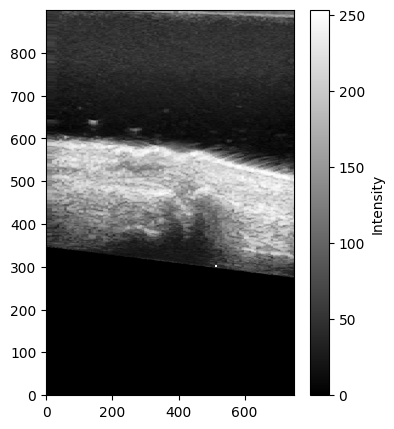

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Rotate the slice 90 degrees counterclockwise
rotated_intensity = np.rot90(masked_intensity[:, 300, :], k = -1)

plt.figure(figsize=(4, 5))
plt.imshow(rotated_intensity, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label="Intensity")
plt.show()


In [10]:
np.save("interpolated_intensity_GPU_20250101.npy", interpolated_intensity)